Let's test a trading strategy described on the [Quantified Strategies](http://www.quantifiedstrategies.com/trade-the-boring-consumer-stocks-when-they-open-down-and-yesterday-was-a-down-day/) blog.  <br>




In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp
import tradingWithPython.lib.yahooFinance as yf # yahoo finance functions
from tradingWithPython import sharpe # general trading toolbox functions
import pandas as pd # pandas time series library

twp.extra.setNotebookStyle() # tweak output settings (optional)

In [3]:
ohlc = yf.getHistoricData('XLP')[['open','high','low','close']] # get data from yahoo finance


Got 4551 days of data


In [4]:
ohlc.tail()

open   high    low  close
2017-01-18  52.20  52.45  52.20  52.43
2017-01-19  52.37  52.37  52.12  52.24
2017-01-20  52.49  52.77  52.31  52.58
2017-01-23  52.58  52.61  52.39  52.56
2017-01-24  52.60  52.96  52.58  52.91

Trading volume is not needed for this strategy, so I remove it for now.

             open   high    low  close
1998-12-22  25.88  26.53  25.88  26.50
1998-12-23  26.80  28.80  26.69  27.14
1998-12-24  27.14  27.14  27.00  27.09
1998-12-28  27.14  27.16  26.81  26.94
1998-12-29  26.95  27.56  25.98  27.53
...           ...    ...    ...    ...
2017-01-18  52.20  52.45  52.20  52.43
2017-01-19  52.37  52.37  52.12  52.24
2017-01-20  52.49  52.77  52.31  52.58
2017-01-23  52.58  52.61  52.39  52.56
2017-01-24  52.60  52.96  52.58  52.91

[4551 rows x 4 columns]


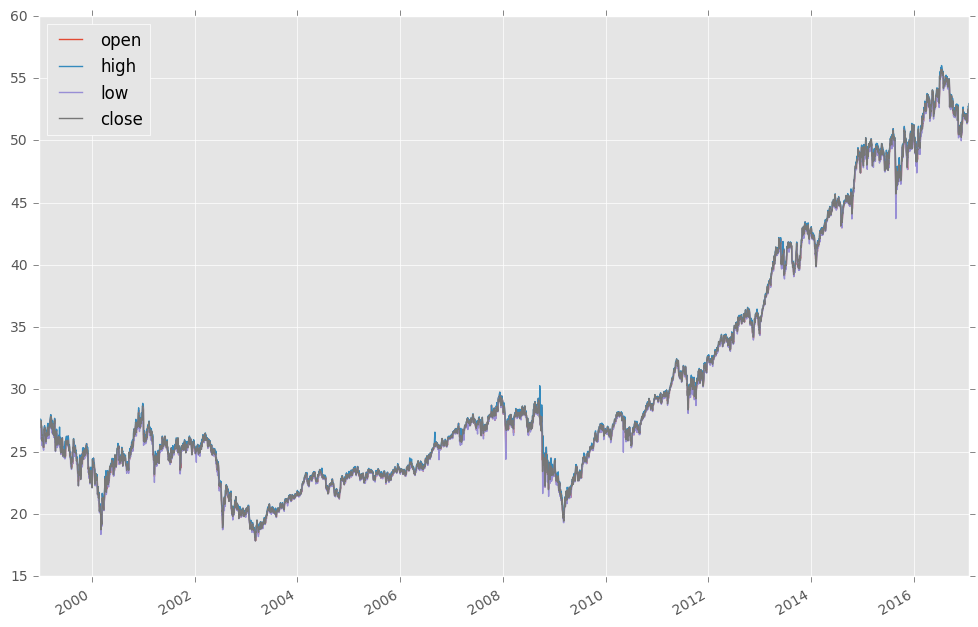

In [5]:
ohlc.plot()
print(ohlc)

The strategy rules are:

* Yesterday must have been a down day of at least 0.25%.
* If XLP opens down more than 0.1% today, go long and exit on the close.


Sharpe buy-and-hold: 0.324482512319


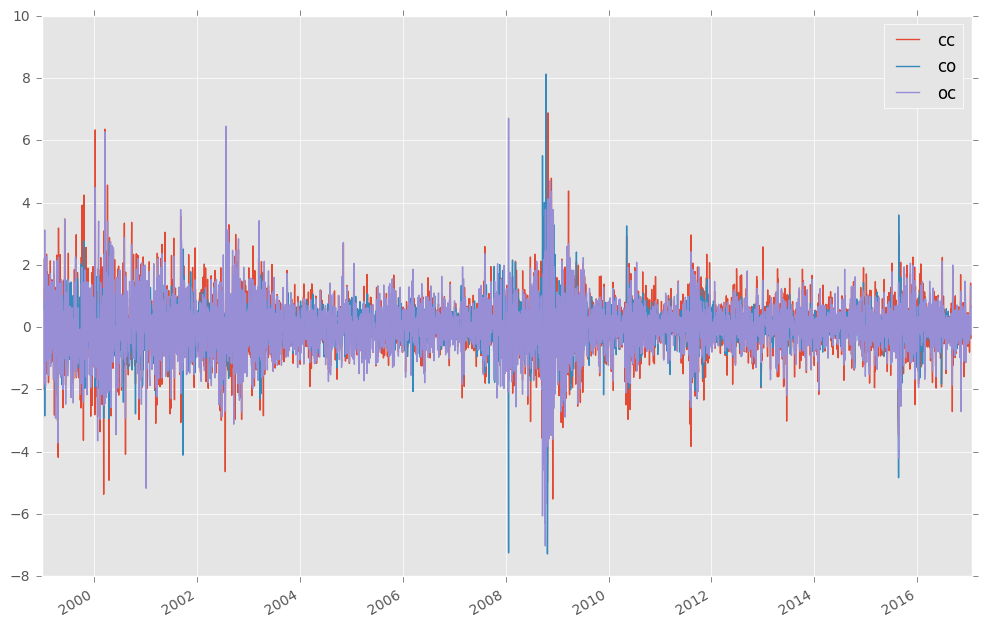

In [6]:
stratData = pd.DataFrame(index=ohlc.index)
stratData['cc'] = 100*ohlc['close'].pct_change() # close-to-close change in %
stratData['co'] = 100*(ohlc['open']/ohlc['close'].shift(1)-1) # previous close to open change in %
stratData['oc'] = 100*(ohlc['close']/ohlc['open']-1) # open to close change in %
stratData.plot()
print('Sharpe buy-and-hold:', sharpe(stratData['cc']))

Let's take a look how these CC, CO and OC returns accumulate over time

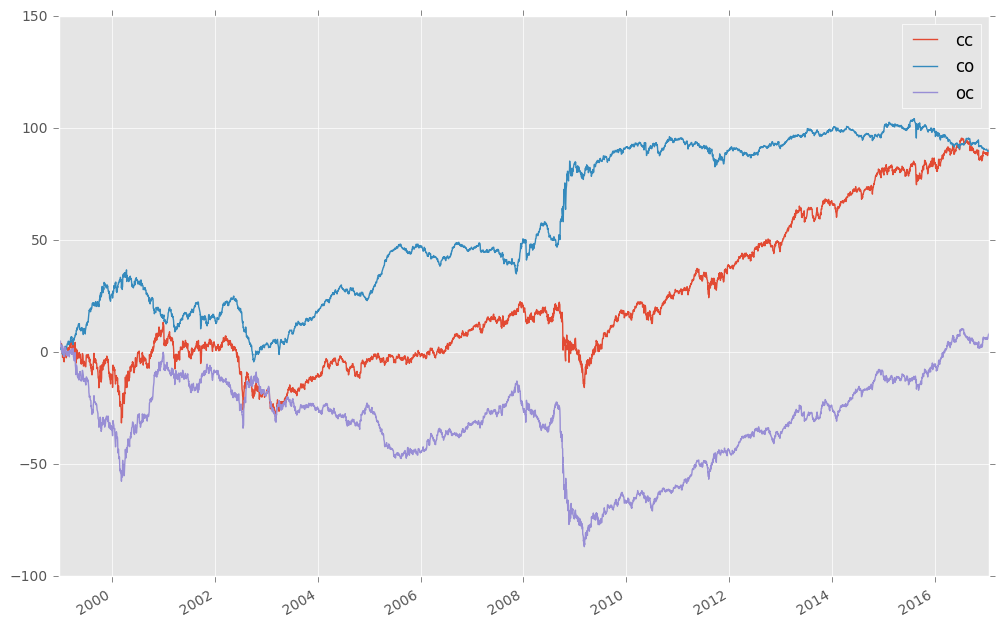

In [7]:
stratData.cumsum().plot(grid=True)

Clearly most of the returns are occuring overnight, from close to open. 

Now let's simulate the strategy.


In [8]:
idx = (stratData['cc']<-0.25).shift(1) & (stratData['co'] < -0.1) # find days that satisfy the strategy rules
idx[0] = False # fill first entry with False (needed because .shift(1) adds a NaN in the first element)

stratData['goLong'] = idx
stratData['pnl'] = 0. # init pnl column with zeros (Watch out: if initialized with integer value (0), an error will pop later on)
stratData.ix[idx,'pnl'] = stratData.ix[idx, 'oc'] # set pnl column values to daily return wehere 'goLong' is true

stratData.tail(20) # show last 10 rows of stratData 

cc    co    oc goLong  pnl
2016-12-23  0.19 -0.06  0.25  False  0.0
2016-12-27 -0.02 -0.08  0.06  False  0.0
2016-12-28 -0.61 -0.08 -0.54  False  0.0
2016-12-29  0.46  0.06  0.41  False  0.0
2016-12-30 -0.50  0.02 -0.52  False  0.0
...          ...   ...   ...    ...  ...
2017-01-18  0.34 -0.10  0.44  False  0.0
2017-01-19 -0.36 -0.11 -0.25  False  0.0
2017-01-20  0.65  0.48  0.17  False  0.0
2017-01-23 -0.04  0.00 -0.04  False  0.0
2017-01-24  0.67  0.08  0.59  False  0.0

[20 rows x 5 columns]

Sharpe: 1.11315820481


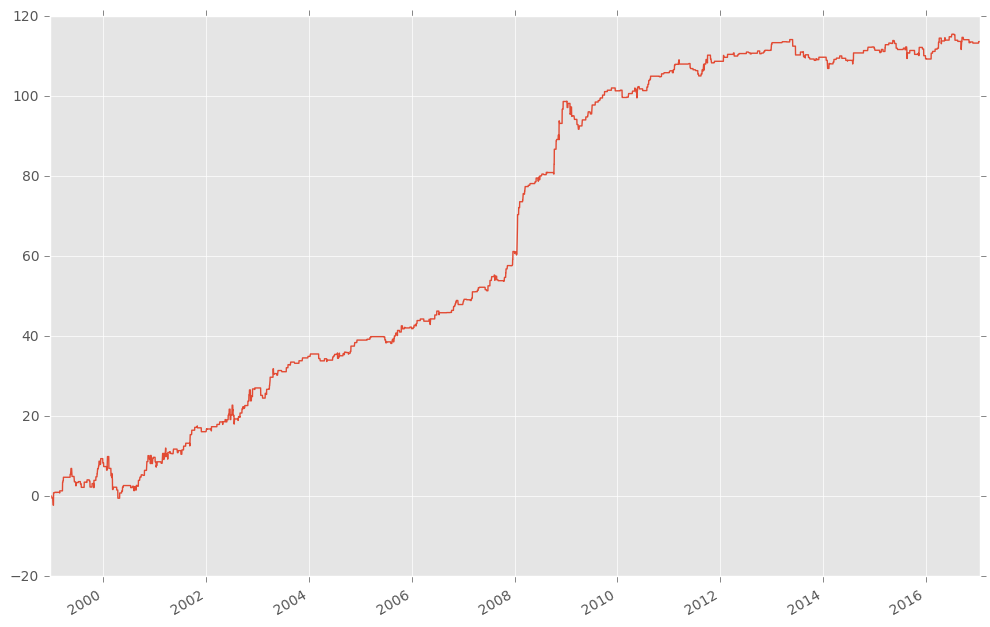

In [9]:
print('Sharpe:' , sharpe(stratData['pnl']))
stratData['pnl'].cumsum().plot()

Ok, this is nice. The result matches with what Oddmund have found. <br> 
But this is actually where the fun really starts, now I'll backtest this strategy with different parameters and also test it on other symbols. <br>
First, let's rewrite the strategy as a function so it is easy to use.

## Rewrite strategy to a single function

Here I'll just copy & paste all the code written above and put it into a function, which returns the pnl timeseries.

In [10]:
def backtest(ohlc, ccThresh=-0.25, coThresh=-0.1):
    ''' Function to backtest the Boring Consumer Stocks strategy '''
    stratData = pd.DataFrame(index=ohlc.index)
    stratData['cc'] = 100*ohlc['close'].pct_change() # close-to-close change in %
    stratData['co'] = 100*(ohlc['open']/ohlc['close'].shift(1)-1) # previous close to open change in %
    stratData['oc'] = 100*(ohlc['close']/ohlc['open']-1) # open to close change in %
    
    idx = (stratData['cc']<ccThresh).shift(1) & (stratData['co'] < coThresh) # find days that satisfy the strategy rules
    idx[0] = False # fill first entry with False (needed because .shift(1) adds a NaN in the first element)

    stratData['goLong'] = idx
    stratData['pnl'] = 0. # init pnl column with zeros (Watch out: if initialized with integer value (0), an error will pop later on)
    stratData.ix[idx,'pnl'] = stratData.ix[idx, 'oc'] # set pnl column values to daily return wehere 'goLong' is true

    return stratData['pnl']
    

Now, test the function with OHLC data, result should be exactly as before

Sharpe: 1.11315820481


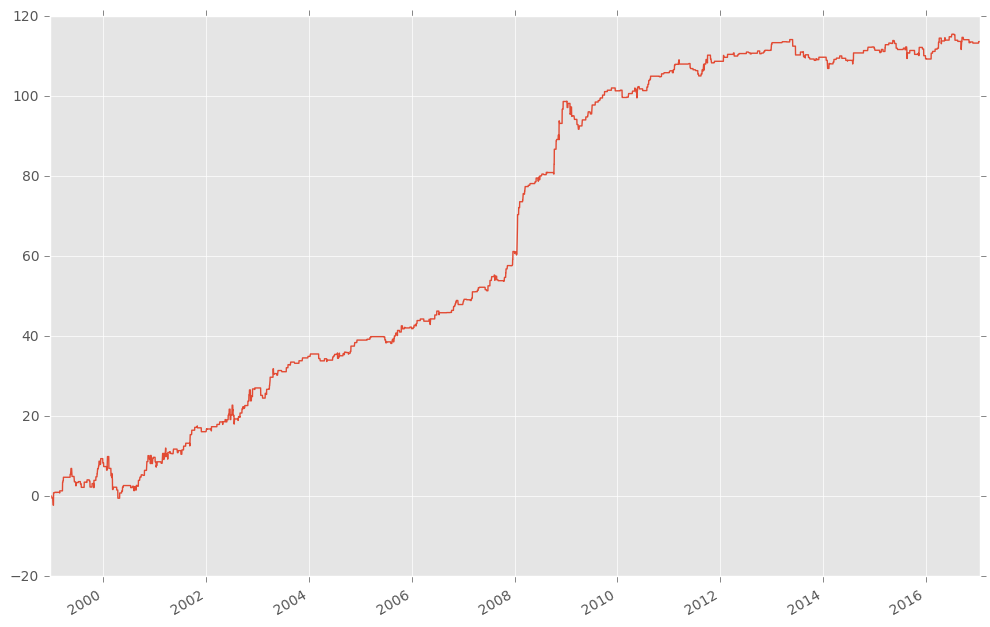

In [11]:
pnl = backtest(ohlc)
pnl.cumsum().plot()
print('Sharpe:', sharpe(pnl))

Indeed, same result. Now we can proceed to scanning parameter values.

## Make a scan of ALL parameters 
We'll also use a nice progress bar to display calculation progress

 [*********************100%***********************]  29 of 29 complete

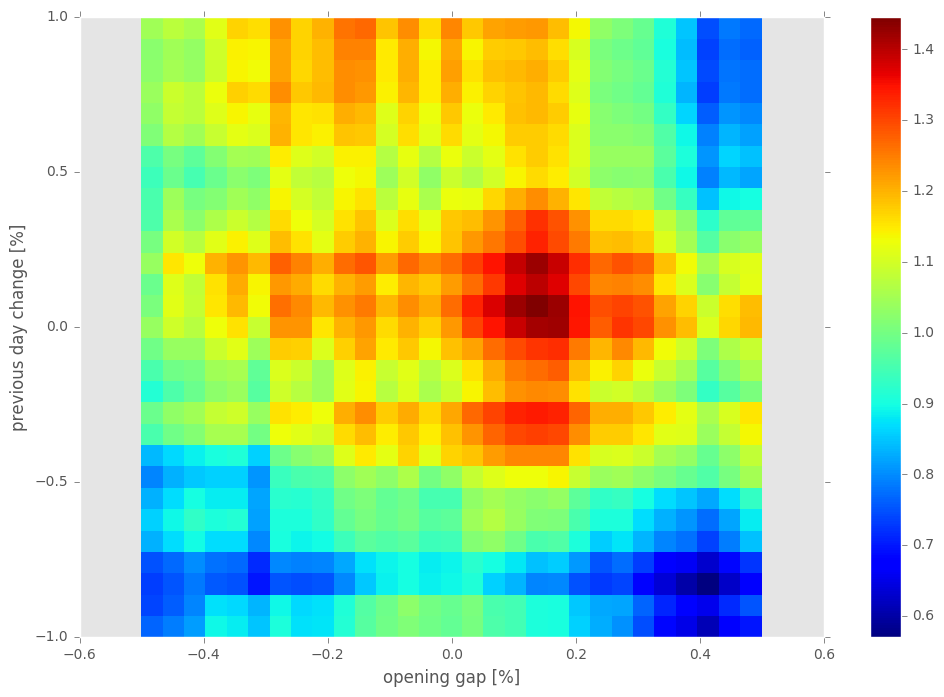

In [12]:
from tradingWithPython.lib.extra import ProgressBar

ccThresh = np.linspace(-1,1,30)
coThresh = np.linspace(-0.5,0.5, 30)

SH = np.zeros((len(ccThresh),len(coThresh)))

pbar = ProgressBar(len(ccThresh)-1)

for i, cc in enumerate(ccThresh):
    pbar.animate(i)
    for j, co in enumerate(coThresh):
        pnl = backtest(ohlc, ccThresh=cc, coThresh=co)
        SH[i,j] = sharpe(pnl)
        
pcolor(coThresh,ccThresh, SH)
xlabel('opening gap [%]')
ylabel('previous day change [%]');
colorbar();

No find the ompimal parameters corresponding to maximum Sharpe ratio.

In [13]:
i,j = np.unravel_index(SH.argmax(), SH.shape)
SH[i,j]
print('Optimum CC %.2f' % ccThresh[i])
print('Optimum CO %.2f' % coThresh[j])

Optimum CC 0.03
Optimum CO 0.12


Sharpe: 1.40947906155


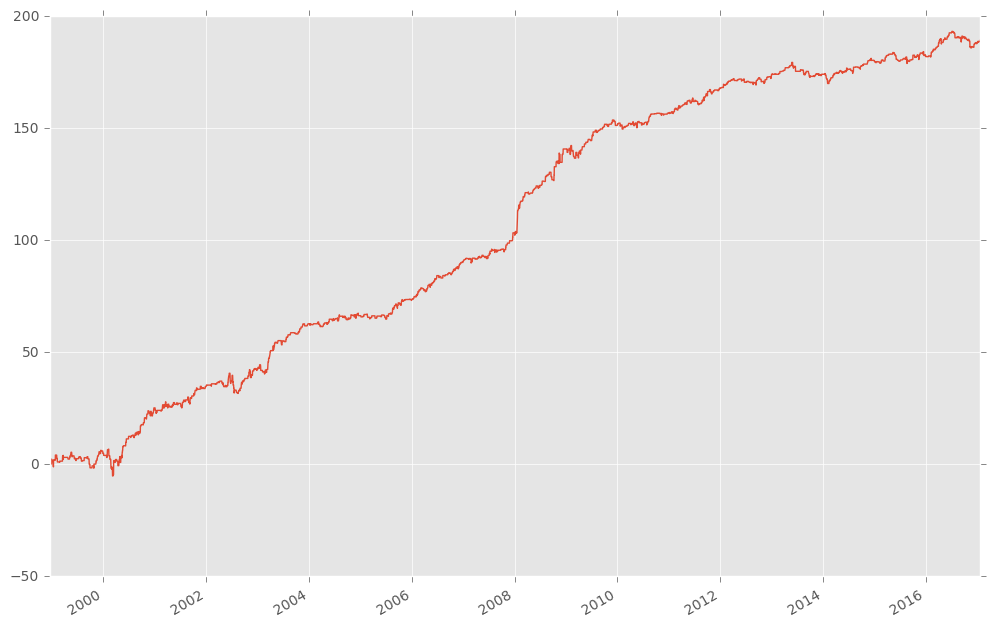

In [14]:
pnl = backtest(ohlc, ccThresh = 0.03, coThresh= 0.09)
print('Sharpe:', sharpe(pnl))
_ = pnl.cumsum().plot()

## Conclusion

The rules of -0.25% / -0.1% can be further improved to achieve a higher Sharpe. However, the strategy performance does not vary that much, it is very stable and performs well for a wide range of settings

# Improvements

## Walk-Forward Optimization

In order to avoid [curve-fitting](http://en.wikipedia.org/wiki/Curve_fitting), we will perform a [walk-forward optimization](http://en.wikipedia.org/wiki/Walk_forward_optimization)

* http://www.easyexpertforex.com/walk-forward-analysis.html

* http://www.tradestation.com/trading-technology/tradestation-platform/analyze/walk-forward-optimizer

A neat way to do this is to create a function that generates two datasets: in- and out-of-sample. The first one is used to optimize the strategy, second one to test its performance. 
The function `generateFWD` below does just that. Take a look at the [generator concept](http://docs.python.org/2/tutorial/classes.html#tut-generators) used in this function. In this way the `yield` of the function can be used in a loop: 

`for trainSet,testSet, tp in generateFWD(ohlc)`

In [15]:
def generateFWD(data,nTrain = 250, nTest=50):
    ''' 
    Walk forward generator. Returns two subsections (in-sample, out-of-sample) of provided dataframe to 
    be used in a walk-forward testing.
    
    Parameters
    -------------
    data : DataFrame containing full dataset
    nTrain : number of periods in a train (in-sample) set
    nTest : number of periods in a test (out-of-sample) set
    
    Returns
    ----------
    (trainSet,testSet,testPoint)
    
    '''
    nTotal = nTrain+nTest
    
    for tp in range(nTrain,len(data) - nTotal, nTest) :  # xrange() is a little more efficient than range()
        # tp is a 'testpoint' which is at in-sample/out-of-sample boundary
        yield (data.iloc[tp-nTrain:tp,:], data.iloc[tp:tp+nTest],tp) # return test and train datasets

def optimize(ohlc):
    ''' find optimal strategy parameters '''
    ccThresh = np.linspace(-1,1,30)
    coThresh = np.linspace(-0.5,0.5, 30)
    
    SH = np.zeros((len(ccThresh),len(coThresh)))
    
    for i, cc in enumerate(ccThresh):
        for j, co in enumerate(coThresh):
            pnl = backtest(ohlc, ccThresh=cc, coThresh=co)
            SH[i,j] = sharpe(pnl)
            
    i,j = np.unravel_index(SH.argmax(), SH.shape)
    SH[i,j]
    
    return ccThresh[i], coThresh[j]  
   
nTest = 250    # number of days in testing period
pnl = []       # results of individual tests, will be combined to a single series later

#we'll need some work to prepare the progress bar by first generating the testpoints. ProgressBar is optional of course.
testPoints = [ tp for _,_,tp in generateFWD(ohlc, nTest=nTest)]
    
pbar =ProgressBar(len(testPoints)-1)    
    
for trainSet,testSet, tp in generateFWD(ohlc,nTest=nTest):
    (cc,co) = optimize(trainSet)
    pnl.append(backtest(testSet, ccThresh = cc, coThresh= co))
    pbar.animate(testPoints.index(tp))

 [*********************100%***********************]  15 of 15 complete

In [17]:
pnl

[1999-12-20    0.00
 1999-12-21    0.00
 1999-12-22    0.00
 1999-12-23    0.00
 1999-12-27    0.00
               ... 
 2000-12-07    0.00
 2000-12-08    0.00
 2000-12-11   -0.46
 2000-12-12    0.00
 2000-12-13    0.00
 Name: pnl, dtype: float64, 2000-12-14    0.00
 2000-12-15    0.00
 2000-12-18    1.33
 2000-12-19    0.00
 2000-12-20    0.00
               ... 
 2001-12-11    0.00
 2001-12-12    0.00
 2001-12-13    0.00
 2001-12-14   -0.36
 2001-12-17    0.00
 Name: pnl, dtype: float64, 2001-12-18    0.00
 2001-12-19    0.00
 2001-12-20    0.00
 2001-12-21    0.00
 2001-12-24    0.00
               ... 
 2002-12-09    0.00
 2002-12-10    1.09
 2002-12-11    0.00
 2002-12-12   -0.15
 2002-12-13    0.40
 Name: pnl, dtype: float64, 2002-12-16    0.0
 2002-12-17    0.0
 2002-12-18    0.0
 2002-12-19    0.0
 2002-12-20    0.0
              ... 
 2003-12-05    0.0
 2003-12-08    0.0
 2003-12-09    0.0
 2003-12-10    0.0
 2003-12-11    0.0
 Name: pnl, dtype: float64, 2003-12-12    0.00
 20

Sharpe: 1.30


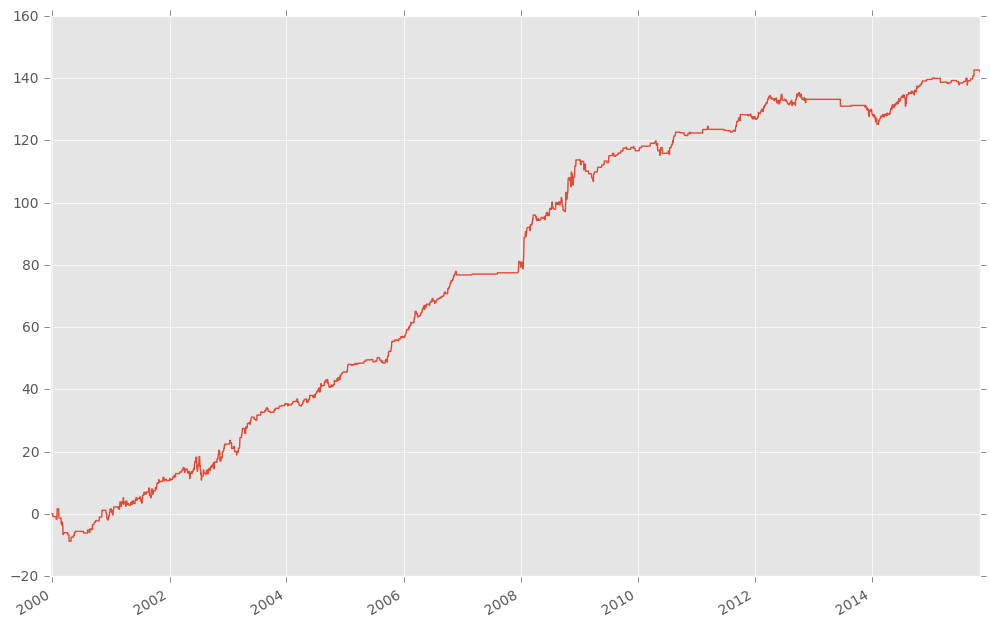

In [16]:
PNL = pd.concat(pnl) # combine to a single series
PNL.cumsum().plot()
print('Sharpe: %.2f' % sharpe(PNL))

So, the strategy seems to perform quite well out-of-sample

In [18]:
print('Sharpe: %.2f' % sharpe(PNL))

Sharpe: 1.30
